In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, get_h, chirp2total, shifted_f, shifted_e, match_wfs, overlap_cplx_wfs, match_h1_h2
from pycbc.types import timeseries
from pycbc.filter import match

# h1 shifted frequency with match fn

In [3]:
# Calculates match over range of intial frequency values
def s_f_h1_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Matches against h1
        match = match_wfs(h1, s, f_low, subsample_interpolation=subsample_interpolation)
        s_f_matches_1.append(abs(match))
    
        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['h1'] = s_f_matches_1
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    return data

In [4]:
# Makes plot of quad match data
def plot_s_f_h1_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01)):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='solid', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

First with subsample_interpolation=False

In [5]:
start = time.time()
sample_rate = 4096
dataslot_0 = s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10, subsample_interpolation=False)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 72.83671545982361 seconds


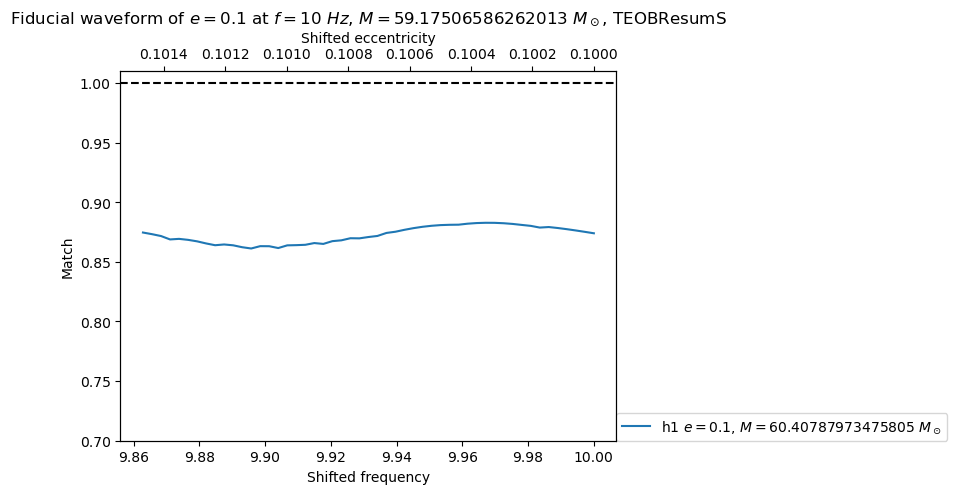

In [6]:
plot_s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_0, 10, ylims=(0.7,1.01))

Now with subsample_interpolation=True

In [7]:
start = time.time()
sample_rate = 4096
dataslot_1 = s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10, subsample_interpolation=True)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 72.69077038764954 seconds


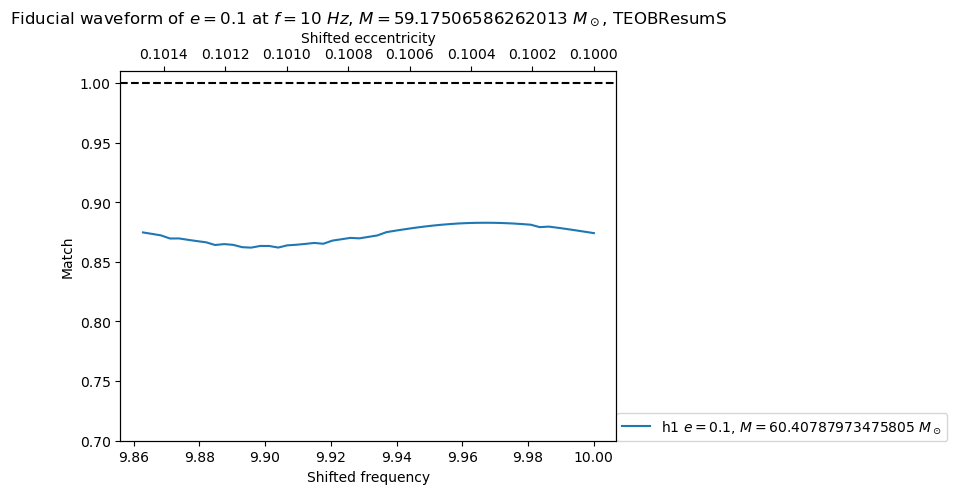

In [8]:
plot_s_f_h1_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_1, 10, ylims=(0.7,1.01))

# Understanding match fn index shift

1.0000000000000002 1000
1.0 2000


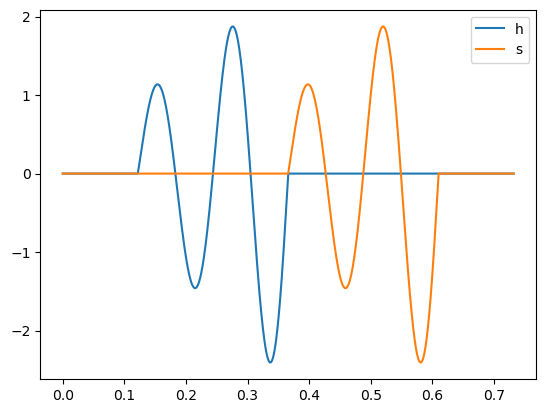

In [3]:
# Create test waveforms
times = np.linspace(1, 1000, 1000)
strain_1_insert = np.sin(2*np.pi*times/500)*np.exp(times/1000)
strain_1_h = np.array(list(np.zeros(500)) + list(strain_1_insert) + list(np.zeros(1500)))
strain_1_s = np.array(list(np.zeros(1500)) + list(strain_1_insert) + list(np.zeros(500)))
test_1_h = timeseries.TimeSeries(strain_1_h, 1/4096, epoch=0)
test_1_s = timeseries.TimeSeries(strain_1_s, 1/4096, epoch=0)

# Plot
plt.plot(test_1_h.sample_times, test_1_h, label='h')
plt.plot(test_1_s.sample_times, test_1_s, label='s')
plt.legend()

# Calculate match both ways around
m, i = match(test_1_h, test_1_s)
print(m, i)
m, i = match(test_1_s, test_1_h)
print(m, i)

Seems like outputted index is how many indices to shift first waveform by to match second. Also seems like this is cyclic, so instead of outputting a negative index shift, will output len(wf) - abs(negative shift).

# Testing match_h1_h2() function

If we input one of the trial 'waveforms' above as both h1 and h2, and the other as the trial waveform, we should hope to get the same (or very similar) match back out. We also expect this to work both ways around (i.e. for forward and backward shifts).

In [4]:
print(match_h1_h2(test_1_h, test_1_h, test_1_s, 2, return_index=True))
print(match_h1_h2(test_1_s, test_1_s, test_1_h, 2, return_index=True))

((1.0000000000000002+5.699196992113317e-17j), (0.9999999999999997-5.5479101737520995e-18j), 1000.0)
((1.0000000000000002-7.461113919362633e-17j), (0.9999999999999997-5.5479101737520995e-18j), 3096.0)


In all cases the match is almost exactly 1, with a phase of zero, as expected. Index shifts are also as expected, as the waveform lengths are resized to 4096 before the first match.

Now try with actual simulated waveforms. First off with no shifted frequency (so we expect no time shift required).

In [5]:
sample_rate = 4096
_, h1, h2, _, _ = get_h([1,1], 10, 0.1, chirp2total(24, 2), 2, sample_rate,
                                    approximant='TEOBResumS', subsample_interpolation=True)
s = gen_wf(10, 0.1, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS')

m1, m2, index = match_h1_h2(h1, h2, s, 10, return_index=True)
print(abs(m1), abs(m2), np.sqrt(abs(m1)**2+abs(m2)**2), index)

0.9925085400212629 0.11585616954223497 0.9992476439982924 0.14016309108176425


Match values look sensible, with quad match almost exactly 1 as expected, and there is (almost) no time shift also as expected.

Finally, test with the trial waveform shifted back by an arbitrary iirational amount of true anomaly.

In [6]:
sample_rate = 4096
s_f = np.sqrt(2)*shifted_f(10, 0.1, chirp2total(24, 2), 2)
s_e = shifted_e(s_f, 10, 0.1)
s = gen_wf(s_f, s_e, chirp2total(24, 2), 2, sample_rate, 'TEOBResumS')

m1, m2, index = match_h1_h2(h1, h2, s, 10, return_index=True)
print(abs(m1), abs(m2), np.sqrt(abs(m1)**2+abs(m2)**2), index)

0.9912176584636441 0.10250551518831338 0.9965038018463206 16897.517094364925


This again looks sensible.

# Shifted frequency plots with match_h1_h2()

In [7]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_M, s_f_len, f_low, approximant='TEOBResumS', subsample_interpolation=True):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, _, _ = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    gridsize = s_f_len
    progress = 0
    e, M = e_M
    
    # Creates grid dimension of shifted frequency
    max_s_f = shifted_f(f_low, e, M, fiducials[2])
    s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
    s_e_vals = shifted_e(s_f_vals, f_low, e)
    s_f_matches_1 = []
    s_f_matches_2 = []
    s_f_matches_quad = []

    # Loops over each initial frequency
    for s_f, s_e in zip(s_f_vals, s_e_vals):

        # Create waveform to match
        s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

        # Matches against h1 and h2
        m1, m2 = match_h1_h2(h1, h2, s, f_low)
        s_f_matches_1.append(abs(m1))
        s_f_matches_2.append(abs(m2))
        s_f_matches_quad.append(np.sqrt(abs(m1)**2+abs(m2)**2))
    
        # Progress bar
        progress += 1
        print('\r' + f'{progress} done out of {gridsize}', end='')

    # Saves data
    data['h1'] = s_f_matches_1
    data['h2'] = s_f_matches_2
    data['quad'] = s_f_matches_quad
    data['s_f_vals'] = s_f_vals
    data['s_e_vals'] = s_e_vals

    return data

In [11]:
# Makes plot of quad match data
def plot_s_f_quad_match(fiducials, e_M, data, f_low, approximant='TEOBResumS', ylims=(0.9,1.01)):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
        
    # Makes plot
    e, M = e_M
    ax1.plot(data['s_f_vals'], data['h1'], ls='dashed', c=f'C0', label=f'h1 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['h2'], ls='solid', c=f'C0', label=f'h2 $e={e}$, $M={M}~M_\odot$')
    ax1.plot(data['s_f_vals'], data['quad'], ls='solid', c=f'C0', label=f'quad $e={e}$, $M={M}~M_\odot$')
    ax1.set_xlabel('Shifted frequency')
    ax2.plot(data['s_e_vals'], data['h1'], alpha=0)
    ax2.invert_xaxis()
    ax2.set_xlabel('Shifted eccentricity')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

In [13]:
start = time.time()
sample_rate = 4096
dataslot_2 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 81.91004681587219 seconds


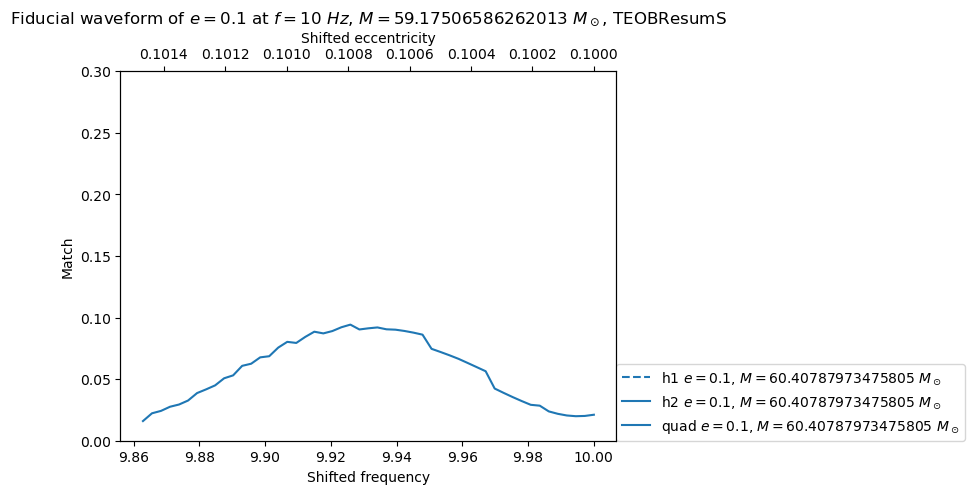

In [18]:
#plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_2, 10, ylims=(0.7,1.01)) # Plot zoom of h1, quad
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_2, 10, ylims=(0,0.3)) # Plot zoom of h2

In [15]:
start = time.time()
sample_rate = 16384
dataslot_3 = s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), 51, 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

51 done out of 51
Time taken: 112.11896967887878 seconds


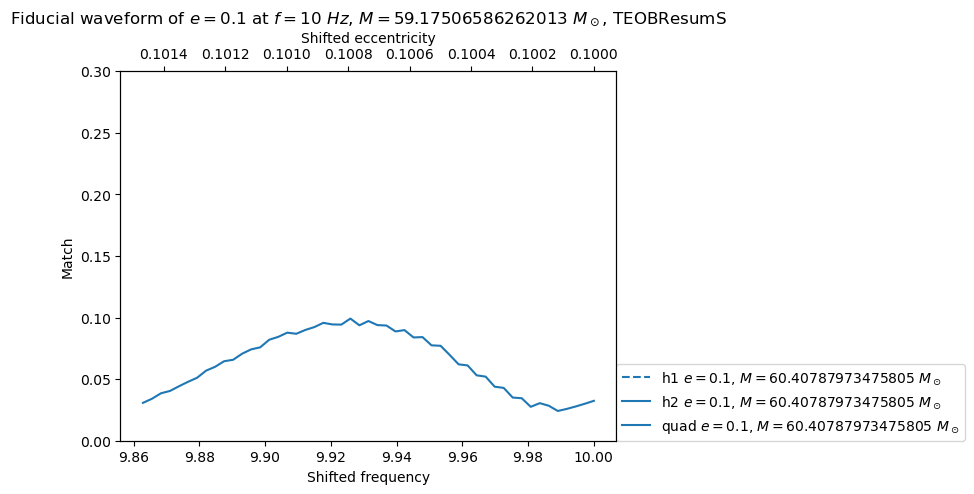

In [19]:
#plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, ylims=(0.7,1.01)) # Plot zoom of h1, quad
plot_s_f_quad_match([0.1, chirp2total(24, 2), 2], (0.10, chirp2total(24.50, 2)), dataslot_3, 10, ylims=(0,0.3)) # Plot zoom of h2